In [92]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
import pandas as pd
idx = pd.IndexSlice

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression

from datetime import timedelta

s = '2017-11-01'
e = '2017-12-20'

%aimport trans.data
%aimport trans.gtrans
%aimport trans.reg

from trans.data import GetData as gd
from trans.gtrans import *

from trans.reg import Reg

from trans.gtrans import DataFrameFunctionTransformer 

pctTrans = DataFrameFunctionTransformer(func = lambda s: s.pct_change())
rankTrans = DataFrameFunctionTransformer(func = lambda s: s.rank(method="first"), axis=1)
pctOnlyTrans = GenSelectAttrsTransformer(['Pct'], dropSingle=False )

In [94]:
%aimport trans.data
ai = gd.combine_data(['FB', 'AAPL', 'AMZN', 
                           'NFLX', 'GOOG', 'SPY'])
ai.head()

0


Open                                          High            \
             FB      AAPL     AMZN NFLX GOOG         SPY   FB      AAPL   
Date                                                                      
2000-01-03  NaN  3.745536  81.5000  NaN  NaN  148.250000  NaN  4.017857   
2000-01-04  NaN  3.866071  85.3750  NaN  NaN  143.531204  NaN  3.950893   
2000-01-05  NaN  3.705357  70.5000  NaN  NaN  139.937500  NaN  3.948661   
2000-01-06  NaN  3.790179  71.3125  NaN  NaN  139.625000  NaN  3.821429   
2000-01-07  NaN  3.446429  67.0000  NaN  NaN  140.312500  NaN  3.607143   

                            ...    Adj Close                       Volume  \
               AMZN NFLX    ...         AMZN NFLX GOOG         SPY     FB   
Date                        ...                                             
2000-01-03  89.5625  NaN    ...      89.3750  NaN  NaN  103.807343    NaN   
2000-01-04  91.5000  NaN    ...      81.9375  NaN  NaN   99.747833    NaN   
2000-01-05  75.1250  NaN    ...      69.7500  NaN  NaN   99.926254    NaN   
2000-01-06  72.6875  NaN    ...      65.5625  NaN  NaN   98.320305    NaN   
2000-01-07  70.5000  NaN    ...      69.5625  NaN  NaN  104.030365    NaN   

                                                     
                 AAPL      AMZN NFLX GOOG       SPY  
Date                                                 
2000-01-03  133949200  16117600  NaN  NaN   8164300  
2000-01-04  128094400  17487400  NaN  NaN   8089800  
2000-01-05  194580400  38457400  NaN  NaN  12177900  
2000-01-06  191993200  18752000  NaN  NaN   6227200  
2000-01-07  115183600  10505400  NaN  NaN   8066500  

[5 rows x 36 columns]

In [95]:
#all_ids = pd.concat([ all, ids_all ], axis=1)
#all_ids.head()
all_ids = gd.compile_data_all(['FB', 'AAPL', 'AMZN', 
                           'NFLX', 'GOOG', 'SPY'])
all_ids.head()
ai = all_ids.swaplevel(axis=1,i=0,j=1)
ai.sortlevel(axis=1, inplace=True)
ai.head()
#ai.loc[:, idx['Adj Close',:]].head()

pipe_close = make_pipeline(GenSelectAttrsTransformer(['Adj Close'], dropSingle=True )
                      )   

pipe_pct   = make_pipeline(GenSelectAttrsTransformer(['Adj Close'], dropSingle=True ), 
                         pctTrans,
                      )

featUn = GenDataFrameFeatureUnion( [ ("Adj Close", pipe_close),
                                    ("Pct", pipe_pct)
                                   ] )
fud = featUn.fit_transform(ai)
fud.tail()

lr=LinearRegression()

# Can set x_vals either of the two ways below: needed is to be a column, not a row
x_vals = fud.loc[s:e, idx["Pct", "SPY"]].values.reshape(-1,1)
x_vals = np.matrix( np.asarray(fud.loc[s:e, idx["Pct", "SPY"]])).T

y_vals = fud.loc[s:e, idx["Pct", "AAPL"]] 
lr.fit( x_vals,  y_vals)
lr.coef_
lr.intercept_

from trans.gtrans import *
fud2 =  DatetimeIndexTransformer("Dt").transform(fud)
fud2.head()
fud2.index

0


FB                                      AAPL                      \
           Open High Low Close Adj Close Volume      Open      High       Low   
Date                                                                            
2000-01-03  NaN  NaN NaN   NaN       NaN    NaN  3.745536  4.017857  3.631696   
2000-01-04  NaN  NaN NaN   NaN       NaN    NaN  3.866071  3.950893  3.613839   
2000-01-05  NaN  NaN NaN   NaN       NaN    NaN  3.705357  3.948661  3.678571   
2000-01-06  NaN  NaN NaN   NaN       NaN    NaN  3.790179  3.821429  3.392857   
2000-01-07  NaN  NaN NaN   NaN       NaN    NaN  3.446429  3.607143  3.410714   

                        ...    GOOG                                SPY  \
               Close    ...     Low Close Adj Close Volume        Open   
Date                    ...                                              
2000-01-03  3.997768    ...     NaN   NaN       NaN    NaN  148.250000   
2000-01-04  3.660714    ...     NaN   NaN       NaN    NaN  143.531204   
2000-01-05  3.714286    ...     NaN   NaN       NaN    NaN  139.937500   
2000-01-06  3.392857    ...     NaN   NaN       NaN    NaN  139.625000   
2000-01-07  3.553571    ...     NaN   NaN       NaN    NaN  140.312500   

                                                                    
                  High         Low     Close   Adj Close    Volume  
Date                                                                
2000-01-03  148.250000  143.875000  145.4375  103.807343   8164300  
2000-01-04  144.062500  139.640594  139.7500   99.747833   8089800  
2000-01-05  141.531204  137.250000  140.0000   99.926254  12177900  
2000-01-06  141.500000  137.750000  137.7500   98.320305   6227200  
2000-01-07  145.750000  140.062500  145.7500  104.030365   8066500  

[5 rows x 36 columns]

Open                                          High            \
             FB      AAPL     AMZN NFLX GOOG         SPY   FB      AAPL   
Date                                                                      
2000-01-03  NaN  3.745536  81.5000  NaN  NaN  148.250000  NaN  4.017857   
2000-01-04  NaN  3.866071  85.3750  NaN  NaN  143.531204  NaN  3.950893   
2000-01-05  NaN  3.705357  70.5000  NaN  NaN  139.937500  NaN  3.948661   
2000-01-06  NaN  3.790179  71.3125  NaN  NaN  139.625000  NaN  3.821429   
2000-01-07  NaN  3.446429  67.0000  NaN  NaN  140.312500  NaN  3.607143   

                            ...    Adj Close                       Volume  \
               AMZN NFLX    ...         AMZN NFLX GOOG         SPY     FB   
Date                        ...                                             
2000-01-03  89.5625  NaN    ...      89.3750  NaN  NaN  103.807343    NaN   
2000-01-04  91.5000  NaN    ...      81.9375  NaN  NaN   99.747833    NaN   
2000-01-05  75.1250  NaN    ...      69.7500  NaN  NaN   99.926254    NaN   
2000-01-06  72.6875  NaN    ...      65.5625  NaN  NaN   98.320305    NaN   
2000-01-07  70.5000  NaN    ...      69.5625  NaN  NaN  104.030365    NaN   

                                                     
                 AAPL      AMZN NFLX GOOG       SPY  
Date                                                 
2000-01-03  133949200  16117600  NaN  NaN   8164300  
2000-01-04  128094400  17487400  NaN  NaN   8089800  
2000-01-05  194580400  38457400  NaN  NaN  12177900  
2000-01-06  191993200  18752000  NaN  NaN   6227200  
2000-01-07  115183600  10505400  NaN  NaN   8066500  

[5 rows x 36 columns]

Adj Close                                                    \
                    FB        AAPL         AMZN        NFLX         GOOG   
Date                                                                       
2017-12-22  177.199997  175.009995  1168.359985  189.940002  1060.119995   
2017-12-26  175.990005  170.570007  1176.760010  187.759995  1056.739990   
2017-12-27  177.619995  170.600006  1182.260010  186.240005  1049.369995   
2017-12-28  177.919998  171.080002  1186.099976  192.710007  1048.140015   
2017-12-29  176.460007  169.229996  1169.469971  191.960007  1046.400024   

                             Pct                                          \
                   SPY        FB      AAPL      AMZN      NFLX      GOOG   
Date                                                                       
2017-12-22  267.510010 -0.001409  0.000000 -0.005448  0.006998 -0.003300   
2017-12-26  267.190002 -0.006828 -0.025370  0.007190 -0.011477 -0.003188   
2017-12-27  267.320007  0.009262  0.000176  0.004674 -0.008095 -0.006974   
2017-12-28  267.869995  0.001689  0.002814  0.003248  0.034740 -0.001172   
2017-12-29  266.859985 -0.008206 -0.010814 -0.014021 -0.003892 -0.001660   

                      
                 SPY  
Date                  
2017-12-22 -0.000262  
2017-12-26 -0.001196  
2017-12-27  0.000487  
2017-12-28  0.002057  
2017-12-29 -0.003771

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

array([ 1.42386037])

-0.00071338708618964939

Adj Close                                          Pct            \
                  FB      AAPL     AMZN NFLX GOOG         SPY  FB      AAPL   
Dt                                                                            
2000-01-03       NaN  3.583733  89.3750  NaN  NaN  103.807343 NaN       NaN   
2000-01-04       NaN  3.281587  81.9375  NaN  NaN   99.747833 NaN -0.084310   
2000-01-05       NaN  3.329610  69.7500  NaN  NaN   99.926254 NaN  0.014634   
2000-01-06       NaN  3.041471  65.5625  NaN  NaN   98.320305 NaN -0.086538   
2000-01-07       NaN  3.185540  69.5625  NaN  NaN  104.030365 NaN  0.047368   

                                          
                AMZN NFLX GOOG       SPY  
Dt                                        
2000-01-03       NaN  NaN  NaN       NaN  
2000-01-04 -0.083217  NaN  NaN -0.039106  
2000-01-05 -0.148741  NaN  NaN  0.001789  
2000-01-06 -0.060036  NaN  NaN -0.016071  
2000-01-07  0.061010  NaN  NaN  0.058076

DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2017-12-15', '2017-12-18', '2017-12-19', '2017-12-20',
               '2017-12-21', '2017-12-22', '2017-12-26', '2017-12-27',
               '2017-12-28', '2017-12-29'],
              dtype='datetime64[ns]', name='Dt', length=4528, freq=None)

In [96]:
from trans.reg import Reg

# Reduce to have only "Pct" attrs since all non-dep columns will become independents
%aimport trans.reg

# pipe_pct_only = make_pipeline(GenSelectAttrsTransformer(['Pct'] )
pipe_pct_only   = make_pipeline(GenSelectAttrsTransformer(['Pct'], dropSingle=False ) )    

fup = pipe_pct_only.fit_transform(fud2)
r = Reg(fup)

In [97]:
rn = Reg(fup.dropna(axis=0, how="any"))
ma = rn.modelCols( [ idx["Pct", "SPY"]])
(i,d) = ma

(a1, e1) = ("01/01/2000", "04/14/2000")

res_df = rn.rollingModel( i,  d[1], #idx["Pct", "AAPL"],
                 pd.to_datetime(a1,infer_datetime_format=True),
                 pd.to_datetime(e1, infer_datetime_format=True),
                 timedelta(weeks=4)
            )
res_df

fit: empty dataframe
fit: empty dataframe
fit: empty dataframe


,Beta 0,Beta 1
Dt,,
2000-02-18,NaN,NaN
2000-03-17,NaN,NaN
2000-04-14,NaN,NaN


# One big pipeline, starting from raw data

## One pipeline to make data

In [98]:
pipe_close = make_pipeline(GenSelectAttrsTransformer(['Adj Close'], dropSingle=True )
                      )   

pipe_pct   = make_pipeline(GenSelectAttrsTransformer(['Adj Close'], dropSingle=True ), 
                         pctTrans,
                      )

featUn = GenDataFrameFeatureUnion( [ ("Adj Close", GenSelectAttrsTransformer(['Adj Close'], dropSingle=True )),
                                    ("Pct", pipe_pct)
                                   ] )

data_pl = make_pipeline( featUn,
                         DatetimeIndexTransformer("Dt")
                       )

data_df = data_pl.fit_transform(ai)
data_df.head()

Adj Close                                          Pct            \
                  FB      AAPL     AMZN NFLX GOOG         SPY  FB      AAPL   
Dt                                                                            
2000-01-03       NaN  3.583733  89.3750  NaN  NaN  103.807343 NaN       NaN   
2000-01-04       NaN  3.281587  81.9375  NaN  NaN   99.747833 NaN -0.084310   
2000-01-05       NaN  3.329610  69.7500  NaN  NaN   99.926254 NaN  0.014634   
2000-01-06       NaN  3.041471  65.5625  NaN  NaN   98.320305 NaN -0.086538   
2000-01-07       NaN  3.185540  69.5625  NaN  NaN  104.030365 NaN  0.047368   

                                          
                AMZN NFLX GOOG       SPY  
Dt                                        
2000-01-03       NaN  NaN  NaN       NaN  
2000-01-04 -0.083217  NaN  NaN -0.039106  
2000-01-05 -0.148741  NaN  NaN  0.001789  
2000-01-06 -0.060036  NaN  NaN -0.016071  
2000-01-07  0.061010  NaN  NaN  0.058076

## Second pipeline to prepare the data for regression

In [99]:
reg_input_pl = make_pipeline(  pctOnlyTrans,
                         RestrictToCalendarColTransformer( ("Pct", "SPY")),
                         RestrictToNonNullTransformer("all"),
                         # FillNullTransformer(method="bfill")
                       )

so1 = reg_input_pl.fit_transform(data_df)
so1.head()

Pct                                        
            FB      AAPL      AMZN NFLX GOOG       SPY
Dt                                                    
2000-01-04 NaN -0.084310 -0.083217  NaN  NaN -0.039106
2000-01-05 NaN  0.014634 -0.148741  NaN  NaN  0.001789
2000-01-06 NaN -0.086538 -0.060036  NaN  NaN -0.016071
2000-01-07 NaN  0.047368  0.061010  NaN  NaN  0.058076
2000-01-10 NaN -0.017588 -0.005391  NaN  NaN  0.003431

## One big pipeline for both

In [100]:
pipe_nn = make_pipeline( featUn,
                         DatetimeIndexTransformer("Dt"),
                         pctOnlyTrans,
                         RestrictToCalendarColTransformer( ("Pct", "SPY")),
                         RestrictToNonNullTransformer("all"),
                         # FillNullTransformer(method="bfill")
                       )
so2 = pipe_nn.fit_transform(ai)
so2.head()

Pct                                        
            FB      AAPL      AMZN NFLX GOOG       SPY
Dt                                                    
2000-01-04 NaN -0.084310 -0.083217  NaN  NaN -0.039106
2000-01-05 NaN  0.014634 -0.148741  NaN  NaN  0.001789
2000-01-06 NaN -0.086538 -0.060036  NaN  NaN -0.016071
2000-01-07 NaN  0.047368  0.061010  NaN  NaN  0.058076
2000-01-10 NaN -0.017588 -0.005391  NaN  NaN  0.003431

In [101]:

ra = Reg(so1)
ma = ra.modelCols( [ idx["Pct", "SPY"]])
ma

beta_df = ra.rollingModelAll( *ma, #idx["Pct", "AAPL"],
                 pd.to_datetime("01/01/2000",infer_datetime_format=True),
                 # pd.to_datetime("04/14/2000", infer_datetime_format=True),
                 pd.to_datetime("12/29/2017", infer_datetime_format=True),
                 timedelta(weeks=4)
            )
beta_df.tail()

([('Pct', 'SPY')],
 [('Pct', 'FB'),
  ('Pct', 'AAPL'),
  ('Pct', 'AMZN'),
  ('Pct', 'NFLX'),
  ('Pct', 'GOOG')])

Fit: the following columns have naN:  ['FB']
Fit: the following columns have naN:  ['FB']
Fit: the following columns have naN:  ['FB']
Fit: the following columns have naN:  ['FB']
Fit: the following columns have naN:  ['FB']
Fit: the following columns have naN:  ['FB']
Fit: the following columns have naN:  ['FB']
Fit: the following columns have naN:  ['FB']
Fit: the following columns have naN:  ['FB']
Fit: the following columns have naN:  ['FB']
Fit: the following columns have naN:  ['FB']
Fit: the following columns have naN:  ['FB']
Fit: the following columns have naN:  ['FB']
Fit: the following columns have naN:  ['FB']
Fit: the following columns have naN:  ['FB']
Fit: the following columns have naN:  ['FB']
Fit: the following columns have naN:  ['FB']
Fit: the following columns have naN:  ['FB']
Fit: the following columns have naN:  ['FB']
Fit: the following columns have naN:  ['FB']
Fit: the following columns have naN:  ['FB']
Fit: the following columns have naN:  ['FB']
Fit: the f

Beta 0                                            Beta 1  \
                  FB      AAPL      AMZN      NFLX      GOOG        FB   
Dt                                                                       
2017-09-08  0.000231 -0.000272 -0.000858  0.000910  0.000056  1.288074   
2017-10-06 -0.004168 -0.005136 -0.001802  0.000013  0.001119  2.566470   
2017-11-03 -0.000019  0.003963  0.001401 -0.000820  0.000439  2.509251   
2017-12-01 -0.002488 -0.001837  0.001098 -0.006099 -0.002125  1.164516   
2017-12-29 -0.000183 -0.001793 -0.000217  0.000821  0.001072  0.859952   

                                                    
                AAPL      AMZN      NFLX      GOOG  
Dt                                                  
2017-09-08  1.285798  1.464521  1.292776  1.239199  
2017-10-06  2.281003  1.691252  3.312801  0.923909  
2017-11-03  1.733427  6.054137  1.734489  2.880951  
2017-12-01  1.339091  1.082630  2.177337  0.837844  
2017-12-29  1.699265  0.767625  0.908602  1.081924

In [102]:
beta_df.shape

(234, 10)

## Remember that the index for betas is at a lower frequency than index for data

In [103]:
data_df.index
beta_df.index

DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2017-12-15', '2017-12-18', '2017-12-19', '2017-12-20',
               '2017-12-21', '2017-12-22', '2017-12-26', '2017-12-27',
               '2017-12-28', '2017-12-29'],
              dtype='datetime64[ns]', name='Dt', length=4528, freq=None)

DatetimeIndex(['2000-02-18', '2000-03-17', '2000-04-14', '2000-05-12',
               '2000-06-09', '2000-07-07', '2000-08-04', '2000-09-01',
               '2000-09-29', '2000-10-27',
               ...
               '2017-04-21', '2017-05-19', '2017-06-16', '2017-07-14',
               '2017-08-11', '2017-09-08', '2017-10-06', '2017-11-03',
               '2017-12-01', '2017-12-29'],
              dtype='datetime64[ns]', name='Dt', length=234, freq='4W-FRI')

In [104]:

concatTrans = DataFrameConcat( [ data_df, beta_df ])
ret_and_beta_df = concatTrans.fit_transform(pd.DataFrame())
ret_and_beta_df.tail()
ret_and_beta_df.shape

Adj Close                                                    \
                  AAPL         AMZN          FB         GOOG        NFLX   
Dt                                                                         
2017-12-22  175.009995  1168.359985  177.199997  1060.119995  189.940002   
2017-12-26  170.570007  1176.760010  175.990005  1056.739990  187.759995   
2017-12-27  170.600006  1182.260010  177.619995  1049.369995  186.240005   
2017-12-28  171.080002  1186.099976  177.919998  1048.140015  192.710007   
2017-12-29  169.229996  1169.469971  176.460007  1046.400024  191.960007   

                          Beta 0                                  ...     \
                   SPY      AAPL      AMZN        FB      GOOG    ...      
Dt                                                                ...      
2017-12-22  267.510010       NaN       NaN       NaN       NaN    ...      
2017-12-26  267.190002       NaN       NaN       NaN       NaN    ...      
2017-12-27  267.320007       NaN       NaN       NaN       NaN    ...      
2017-12-28  267.869995       NaN       NaN       NaN       NaN    ...      
2017-12-29  266.859985 -0.001793 -0.000217 -0.000183  0.001072    ...      

              Beta 1                                     Pct            \
                AMZN        FB      GOOG      NFLX      AAPL      AMZN   
Dt                                                                       
2017-12-22       NaN       NaN       NaN       NaN  0.000000 -0.005448   
2017-12-26       NaN       NaN       NaN       NaN -0.025370  0.007190   
2017-12-27       NaN       NaN       NaN       NaN  0.000176  0.004674   
2017-12-28       NaN       NaN       NaN       NaN  0.002814  0.003248   
2017-12-29  0.767625  0.859952  1.081924  0.908602 -0.010814 -0.014021   

                                                    
                  FB      GOOG      NFLX       SPY  
Dt                                                  
2017-12-22 -0.001409 -0.003300  0.006998 -0.000262  
2017-12-26 -0.006828 -0.003188 -0.011477 -0.001196  
2017-12-27  0.009262 -0.006974 -0.008095  0.000487  
2017-12-28  0.001689 -0.001172  0.034740  0.002057  
2017-12-29 -0.008206 -0.001660 -0.003892 -0.003771  

[5 rows x 22 columns]

(4536, 22)

In [105]:
gd.save_data(data_df, "ret_df.pkl")
gd.save_data(beta_df, "beta_df.pkl")
gd.save_data(ret_and_beta_df, "ret_and_beta_df.pkl")

In [106]:
ret_df = gd.load_data("ret_df.pkl")
beta_df = gd.load_data("beta_df.pkl")

In [107]:
from trans.gtrans import *

concatTrans = DataFrameConcat( [ beta_df ])
r_and_b_df = concatTrans.fit_transform(ret_df)
r_and_b_df.tail()
r_and_b_df.shape

concatTrans = DataFrameConcat( [ ret_df, beta_df ])
r_and_b_df = concatTrans.fit_transform(pd.DataFrame())
r_and_b_df.tail( )
r_and_b_df.shape

Adj Close                                                    \
                  AAPL         AMZN          FB         GOOG        NFLX   
Dt                                                                         
2017-12-22  175.009995  1168.359985  177.199997  1060.119995  189.940002   
2017-12-26  170.570007  1176.760010  175.990005  1056.739990  187.759995   
2017-12-27  170.600006  1182.260010  177.619995  1049.369995  186.240005   
2017-12-28  171.080002  1186.099976  177.919998  1048.140015  192.710007   
2017-12-29  169.229996  1169.469971  176.460007  1046.400024  191.960007   

                          Beta 0                                  ...     \
                   SPY      AAPL      AMZN        FB      GOOG    ...      
Dt                                                                ...      
2017-12-22  267.510010       NaN       NaN       NaN       NaN    ...      
2017-12-26  267.190002       NaN       NaN       NaN       NaN    ...      
2017-12-27  267.320007       NaN       NaN       NaN       NaN    ...      
2017-12-28  267.869995       NaN       NaN       NaN       NaN    ...      
2017-12-29  266.859985 -0.001793 -0.000217 -0.000183  0.001072    ...      

              Beta 1                                     Pct            \
                AMZN        FB      GOOG      NFLX      AAPL      AMZN   
Dt                                                                       
2017-12-22       NaN       NaN       NaN       NaN  0.000000 -0.005448   
2017-12-26       NaN       NaN       NaN       NaN -0.025370  0.007190   
2017-12-27       NaN       NaN       NaN       NaN  0.000176  0.004674   
2017-12-28       NaN       NaN       NaN       NaN  0.002814  0.003248   
2017-12-29  0.767625  0.859952  1.081924  0.908602 -0.010814 -0.014021   

                                                    
                  FB      GOOG      NFLX       SPY  
Dt                                                  
2017-12-22 -0.001409 -0.003300  0.006998 -0.000262  
2017-12-26 -0.006828 -0.003188 -0.011477 -0.001196  
2017-12-27  0.009262 -0.006974 -0.008095  0.000487  
2017-12-28  0.001689 -0.001172  0.034740  0.002057  
2017-12-29 -0.008206 -0.001660 -0.003892 -0.003771  

[5 rows x 22 columns]

(4536, 22)

Adj Close                                                    \
                  AAPL         AMZN          FB         GOOG        NFLX   
Dt                                                                         
2017-12-22  175.009995  1168.359985  177.199997  1060.119995  189.940002   
2017-12-26  170.570007  1176.760010  175.990005  1056.739990  187.759995   
2017-12-27  170.600006  1182.260010  177.619995  1049.369995  186.240005   
2017-12-28  171.080002  1186.099976  177.919998  1048.140015  192.710007   
2017-12-29  169.229996  1169.469971  176.460007  1046.400024  191.960007   

                          Beta 0                                  ...     \
                   SPY      AAPL      AMZN        FB      GOOG    ...      
Dt                                                                ...      
2017-12-22  267.510010       NaN       NaN       NaN       NaN    ...      
2017-12-26  267.190002       NaN       NaN       NaN       NaN    ...      
2017-12-27  267.320007       NaN       NaN       NaN       NaN    ...      
2017-12-28  267.869995       NaN       NaN       NaN       NaN    ...      
2017-12-29  266.859985 -0.001793 -0.000217 -0.000183  0.001072    ...      

              Beta 1                                     Pct            \
                AMZN        FB      GOOG      NFLX      AAPL      AMZN   
Dt                                                                       
2017-12-22       NaN       NaN       NaN       NaN  0.000000 -0.005448   
2017-12-26       NaN       NaN       NaN       NaN -0.025370  0.007190   
2017-12-27       NaN       NaN       NaN       NaN  0.000176  0.004674   
2017-12-28       NaN       NaN       NaN       NaN  0.002814  0.003248   
2017-12-29  0.767625  0.859952  1.081924  0.908602 -0.010814 -0.014021   

                                                    
                  FB      GOOG      NFLX       SPY  
Dt                                                  
2017-12-22 -0.001409 -0.003300  0.006998 -0.000262  
2017-12-26 -0.006828 -0.003188 -0.011477 -0.001196  
2017-12-27  0.009262 -0.006974 -0.008095  0.000487  
2017-12-28  0.001689 -0.001172  0.034740  0.002057  
2017-12-29 -0.008206 -0.001660 -0.003892 -0.003771  

[5 rows x 22 columns]

(4536, 22)

In [108]:
ret_and_beta_df = gd.load_data("ret_and_beta_df.pkl")

In [109]:
cols = beta_df.columns.get_level_values(0).unique().tolist()
betaCols = [ c for c in cols if re.search('^Beta', c) ]

betaCols

['Beta 0', 'Beta 1']

In [110]:
%aimport trans.gtrans
beta_r_pl = make_pipeline( GenSelectAttrsTransformer(betaCols),
                            FillNullTransformer(method="ffill"),
                            GenRenameAttrsTransformer(lambda col: col + ' rolled fwd', level=0)
                         )
beta_rolled_df = beta_r_pl.fit_transform(ret_and_beta_df)
beta_rolled_df.tail()

transform: pandas version <= 0.20.


Beta 0 rolled fwd                                          \
                        AAPL      AMZN        FB      GOOG      NFLX   
Dt                                                                     
2017-12-22         -0.001837  0.001098 -0.002488 -0.002125 -0.006099   
2017-12-26         -0.001837  0.001098 -0.002488 -0.002125 -0.006099   
2017-12-27         -0.001837  0.001098 -0.002488 -0.002125 -0.006099   
2017-12-28         -0.001837  0.001098 -0.002488 -0.002125 -0.006099   
2017-12-29         -0.001793 -0.000217 -0.000183  0.001072  0.000821   

           Beta 1 rolled fwd                                          
                        AAPL      AMZN        FB      GOOG      NFLX  
Dt                                                                    
2017-12-22          1.339091  1.082630  1.164516  0.837844  2.177337  
2017-12-26          1.339091  1.082630  1.164516  0.837844  2.177337  
2017-12-27          1.339091  1.082630  1.164516  0.837844  2.177337  
2017-12-28          1.339091  1.082630  1.164516  0.837844  2.177337  
2017-12-29          1.699265  0.767625  0.859952  1.081924  0.908602

In [111]:
ret_and_beta_df.shape
beta_rolled_df.shape

ret_and_rolled_beta_pl = DataFrameConcat( [ ret_and_beta_df, beta_rolled_df])
ret_and_rolled_beta_df = ret_and_rolled_beta_pl.fit_transform( pd.DataFrame() )
ret_and_rolled_beta_df.tail()

(4536, 22)

(4536, 10)

Adj Close                                                    \
                  AAPL         AMZN          FB         GOOG        NFLX   
Dt                                                                         
2017-12-22  175.009995  1168.359985  177.199997  1060.119995  189.940002   
2017-12-26  170.570007  1176.760010  175.990005  1056.739990  187.759995   
2017-12-27  170.600006  1182.260010  177.619995  1049.369995  186.240005   
2017-12-28  171.080002  1186.099976  177.919998  1048.140015  192.710007   
2017-12-29  169.229996  1169.469971  176.460007  1046.400024  191.960007   

                          Beta 0                                  ...     \
                   SPY      AAPL      AMZN        FB      GOOG    ...      
Dt                                                                ...      
2017-12-22  267.510010       NaN       NaN       NaN       NaN    ...      
2017-12-26  267.190002       NaN       NaN       NaN       NaN    ...      
2017-12-27  267.320007       NaN       NaN       NaN       NaN    ...      
2017-12-28  267.869995       NaN       NaN       NaN       NaN    ...      
2017-12-29  266.859985 -0.001793 -0.000217 -0.000183  0.001072    ...      

           Beta 1 rolled fwd                                     Pct  \
                        AMZN        FB      GOOG      NFLX      AAPL   
Dt                                                                     
2017-12-22          1.082630  1.164516  0.837844  2.177337  0.000000   
2017-12-26          1.082630  1.164516  0.837844  2.177337 -0.025370   
2017-12-27          1.082630  1.164516  0.837844  2.177337  0.000176   
2017-12-28          1.082630  1.164516  0.837844  2.177337  0.002814   
2017-12-29          0.767625  0.859952  1.081924  0.908602 -0.010814   

                                                              
                AMZN        FB      GOOG      NFLX       SPY  
Dt                                                            
2017-12-22 -0.005448 -0.001409 -0.003300  0.006998 -0.000262  
2017-12-26  0.007190 -0.006828 -0.003188 -0.011477 -0.001196  
2017-12-27  0.004674  0.009262 -0.006974 -0.008095  0.000487  
2017-12-28  0.003248  0.001689 -0.001172  0.034740  0.002057  
2017-12-29 -0.014021 -0.008206 -0.001660 -0.003892 -0.003771  

[5 rows x 32 columns]

In [112]:
ret_and_rolled_beta_df.columns

MultiIndex(levels=[['Adj Close', 'Beta 0', 'Beta 0 rolled fwd', 'Beta 1', 'Beta 1 rolled fwd', 'Pct'], ['AAPL', 'AMZN', 'FB', 'GOOG', 'NFLX', 'SPY']],
           labels=[[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5], [0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 5]])

## Really need to select Dep vars, ind vars, not just Pct

In [113]:
reg = Reg(ret_and_rolled_beta_df)

In [114]:
sensAttrs = reg.sensAttrs(ret_and_rolled_beta_df, '^Beta \d+ rolled fwd$')
sensAttrs

['Beta 0 rolled fwd', 'Beta 1 rolled fwd']

In [115]:
depTickers = reg.depTickersFromSensAttrs(ret_and_rolled_beta_df, sensAttrs )
depTickers
depCols = [ ("Pct", t) for t in depTickers ]
depCols

['AAPL', 'AMZN', 'FB', 'GOOG', 'NFLX']

[('Pct', 'AAPL'),
 ('Pct', 'AMZN'),
 ('Pct', 'FB'),
 ('Pct', 'GOOG'),
 ('Pct', 'NFLX')]

In [116]:
reg.addConst(ret_and_rolled_beta_df,("Pct", "1"), 1)

In [117]:
indCols = [ ("Pct", "1"), ("Pct", "SPY")]
indCols

[('Pct', '1'), ('Pct', 'SPY')]

In [118]:
reg_df =reg.retAttrib(ret_and_rolled_beta_df, 
            indCols,
            depCols, 
            sensAttrs)


In [119]:
reg_df.tail()

Contrib from 1                                          \
                     AAPL      AMZN        FB      GOOG      NFLX   
Dt                                                                  
2017-12-22      -0.001837  0.001098 -0.002488 -0.002125 -0.006099   
2017-12-26      -0.001837  0.001098 -0.002488 -0.002125 -0.006099   
2017-12-27      -0.001837  0.001098 -0.002488 -0.002125 -0.006099   
2017-12-28      -0.001837  0.001098 -0.002488 -0.002125 -0.006099   
2017-12-29      -0.001793 -0.000217 -0.000183  0.001072  0.000821   

           Contrib from SPY                                         Predicted  \
                       AAPL      AMZN        FB      GOOG      NFLX      AAPL   
Dt                                                                              
2017-12-22        -0.000350 -0.000283 -0.000305 -0.000219 -0.000569 -0.002187   
2017-12-26        -0.001602 -0.001295 -0.001393 -0.001002 -0.002605 -0.003439   
2017-12-27         0.000652  0.000527  0.000567  0.000408  0.001059 -0.001185   
2017-12-28         0.002755  0.002227  0.002396  0.001724  0.004480  0.000918   
2017-12-29        -0.006407 -0.002894 -0.003242 -0.004079 -0.003426 -0.008200   

                                                       Error            \
                AMZN        FB      GOOG      NFLX      AAPL      AMZN   
Dt                                                                       
2017-12-22  0.000815 -0.002793 -0.002344 -0.006668  0.002187 -0.006262   
2017-12-26 -0.000197 -0.003881 -0.003128 -0.008703 -0.021931  0.007387   
2017-12-27  0.001624 -0.001922 -0.001718 -0.005039  0.001361  0.003049   
2017-12-28  0.003325 -0.000092 -0.000401 -0.001619  0.001896 -0.000077   
2017-12-29 -0.003111 -0.003426 -0.003007 -0.002605 -0.002614 -0.010909   

                                          
                  FB      GOOG      NFLX  
Dt                                        
2017-12-22  0.001384 -0.000956  0.013666  
2017-12-26 -0.002947 -0.000061 -0.002774  
2017-12-27  0.011183 -0.005257 -0.003056  
2017-12-28  0.001781 -0.000771  0.036359  
2017-12-29 -0.004780  0.001347 -0.001287

## What follows are individual tests for regression

In [28]:
r = Reg(fup)
ma = r.modelCols( [ idx["Pct", "SPY"]])
ma

res_df = r.rollingModel( i,  d[1], #idx["Pct", "AAPL"],
                 pd.to_datetime("01/01/2017",infer_datetime_format=True),
                 pd.to_datetime("12/15/2017", infer_datetime_format=True),
                 timedelta(weeks=4)
            )
res_df


res_all = r.rollingModelAll( *ma,
                     pd.to_datetime("01/01/2017",infer_datetime_format=True),
                     pd.to_datetime("12/15/2017", infer_datetime_format=True),
                     timedelta(weeks=4)
            )

res_all.tail()

([('Pct', 'SPY')],
 [('Pct', 'FB'),
  ('Pct', 'AAPL'),
  ('Pct', 'AMZN'),
  ('Pct', 'NFLX'),
  ('Pct', 'GOOG')])

,Beta 0,Beta 1
Dt,,
2017-02-10,0.005502,0.312753
2017-03-10,0.001030,1.229487
2017-04-07,0.001885,1.238555
2017-05-05,0.000930,1.118177
2017-06-02,0.001291,1.259652
2017-06-30,-0.003231,2.051056
2017-07-28,0.000761,1.116566
2017-08-25,0.004471,1.736269
2017-09-22,-0.005043,1.837181


Beta 0                                            Beta 1  \
                  FB      AAPL      AMZN      NFLX      GOOG        FB   
Dt                                                                       
2017-08-25 -0.001146  0.004471 -0.003058 -0.004361 -0.000789  1.330367   
2017-09-22 -0.000666 -0.005043 -0.001650  0.003708 -0.000394  1.546223   
2017-10-20 -0.002937 -0.000649 -0.000298 -0.003120  0.000401  2.840408   
2017-11-17  0.000907  0.004206  0.006652 -0.000563  0.001241  2.027850   
2017-12-15 -0.001744 -0.000759  0.000946 -0.003239  0.001385  1.090508   

                                                    
                AAPL      AMZN      NFLX      GOOG  
Dt                                                  
2017-08-25  1.736269  1.458582  1.558887  1.204069  
2017-09-22  1.837181  1.717658  2.130198  0.871993  
2017-10-20  1.388181  1.163543  3.374871  1.814472  
2017-11-17  2.151098  4.909322  2.579863  2.501433  
2017-12-15  0.979585  0.685293  1.250068  0.470381

In [ ]:
sp500 = gd.save_sp500_tickers()

In [77]:
all = gd.compile_data_all(['FB', 'AAPL', 'AMZN', 
                           'NFLX', 'GOOG'])

0


In [78]:
all.columns

MultiIndex(levels=[['FB', 'AAPL', 'AMZN', 'NFLX', 'GOOG'], ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']],
           labels=[[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4], [0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5]])

In [ ]:
gd.save_data(all, "test_all.pkl")

In [5]:
all = gd.load_data("test_all.pkl")

In [6]:
ids = gd.get_data_from_yahoo2([ 'SPY'])
ids_all = gd.compile_data_all(['SPY'])
gd.save_data(ids_all, "indexes_all.pkl")

Already have SPY
0


In [6]:
ids_all = gd.load_data("indexes_all.pkl")

In [161]:
from trans.gtrans import GenSelectAttrsTransformer
from trans.gtrans import GenRenameAttrsTransformer
from trans.gtrans import GenRankTransformer

pipe_1 = make_pipeline(GenSelectAttrsTransformer(['Adj Close'] ), 
                       pctTrans,
                       GenRenameAttrsTransformer(lambda col: col + ' pct')
                      )

pipe_2 = make_pipeline(GenSelectAttrsTransformer(['Adj Close'] ), 
                       pctTrans, 
                       # rankTrans,
                       GenRankTransformer(),
                       GenRenameAttrsTransformer(lambda col: col + ' rank')
                          )

featU = DataFrameFeatureUnion([ pipe_1, pipe_2 ])
u = featU.fit_transform(ai.head())
u.head()
                    

Adj Close pct                                                  \
                  FB pct  AAPL pct  AMZN pct NFLX pct GOOG pct   SPY pct   
Date                                                                       
2000-01-03           NaN       NaN       NaN      NaN      NaN       NaN   
2000-01-04           NaN -0.084310 -0.083217      NaN      NaN -0.039106   
2000-01-05           NaN  0.014634 -0.148741      NaN      NaN  0.001789   
2000-01-06           NaN -0.086538 -0.060036      NaN      NaN -0.016071   
2000-01-07           NaN  0.047368  0.061010      NaN      NaN  0.058076   

           Adj Close rank                                                   
                  FB rank AAPL rank AMZN rank NFLX rank GOOG rank SPY rank  
Date                                                                        
2000-01-03            NaN       NaN       NaN       NaN       NaN      NaN  
2000-01-04            NaN       0.0       1.0       NaN       NaN      2.0  
2000-01-05            NaN       2.0       0.0       NaN       NaN      1.0  
2000-01-06            NaN       0.0       1.0       NaN       NaN      2.0  
2000-01-07            NaN       0.0       2.0       NaN       NaN      1.0

In [20]:
from trans.gtrans import GenDataFrameFeatureUnion

pipe_1 = make_pipeline(GenSelectAttrsTransformer(['Adj Close'], dropSingle=True ), 
                       pctTrans,
                       # GenRenameAttrTransformer(lambda col: col + ' pct')
                      )
pipe_2 = make_pipeline(GenSelectAttrsTransformer(['Adj Close'], dropSingle=True), 
                       pctTrans,
                       # DataFrameFunctionTransformer(pd.Series.rank, axis=1)
                        GenRankTransformer(),
                       # GenRenameAttrTransformer(lambda col: col + ' rank')
                      )

featUn =  GenDataFrameFeatureUnion( [ ("Pct", pipe_1), ("Rank", pipe_2)])
un = featUn.fit_transform(ai['2000-01-19':'2000-01-27'])
un.tail()

Pct                                         Rank                 \
            FB      AAPL      AMZN NFLX GOOG       SPY   FB AAPL AMZN NFLX   
Date                                                                         
2000-01-21 NaN -0.019273 -0.041506  NaN  NaN -0.002159  NaN  1.0  0.0  NaN   
2000-01-24 NaN -0.045480  0.129909  NaN  NaN -0.028343  NaN  0.0  2.0  NaN   
2000-01-25 NaN  0.056471 -0.012478  NaN  NaN  0.011357  NaN  2.0  0.0  NaN   
2000-01-26 NaN -0.018374 -0.064079  NaN  NaN -0.007927  NaN  1.0  0.0  NaN   
2000-01-27 NaN -0.001702  0.032787  NaN  NaN -0.003994  NaN  1.0  2.0  NaN   

                      
           GOOG  SPY  
Date                  
2000-01-21  NaN  2.0  
2000-01-24  NaN  1.0  
2000-01-25  NaN  1.0  
2000-01-26  NaN  2.0  
2000-01-27  NaN  0.0

In [61]:

un.tail().loc[:, idx[:,'AAPL']]

,Pct,Rank
,AAPL,AAPL
Date,,
2000-01-21,-0.019273,1.0
2000-01-24,-0.045480,0.0
2000-01-25,0.056471,2.0
2000-01-26,-0.018374,1.0
2000-01-27,-0.001702,1.0


In [82]:
lrt = LinearRegression()

pipe_reg = make_pipeline( GenSelectAttrsTransformer(['Pct']),
                        lrt
                         # inearRegression()
                        )
pipe_reg.fit(fud.loc[s:e, idx[:,'SPY']], fud.loc[s:e, idx[:,'AAPL']])
lrt.coef_
lrt.intercept_

Pipeline(steps=[('genselectattrstransformer', GenSelectAttrsTransformer(columns=['Pct'], dropSingle=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

array([[ 73.88078077],
       [  1.42386037]])

array([  1.71981337e+02,  -7.13387086e-04])

## Predictions (second col) are correct; don't know what first col is
## Looks approx like the intercept
## Strangely: lrt.coef_  and lrt.intercept_ are length 2, not length 1

In [83]:
pipe_reg.predict(fud.loc[s:e, idx[:,'SPY']]
                )
pipe_reg.predict(fud.loc[s:e, idx["Pct",'SPY']].to_frame()
                )

array([[  1.72079021e+02,   1.16922634e-03],
       [  1.72010028e+02,  -1.60434879e-04],
       [  1.72228006e+02,   4.04051034e-03],
       [  1.72095677e+02,   1.49021144e-03],
       [  1.71929964e+02,  -1.70347387e-03],
       [  1.72107004e+02,   1.70851035e-03],
       [  1.71713315e+02,  -5.87882411e-03],
       [  1.71958444e+02,  -1.15458592e-03],
       [  1.72050037e+02,   6.10619669e-04],
       [  1.71809748e+02,  -4.02032341e-03],
       [  1.71611540e+02,  -7.84027017e-03],
       [  1.72609394e+02,   1.13907878e-02],
       [  1.71764226e+02,  -4.89764374e-03],
       [  1.72107407e+02,   1.71629042e-03],
       [  1.72464720e+02,   8.60256479e-03],
       [  1.71915981e+02,  -1.97295296e-03],
       [  1.72151982e+02,   2.57534426e-03],
       [  1.71944458e+02,  -1.42413569e-03],
       [  1.72730843e+02,   1.37313979e-02],
       [  1.71936370e+02,  -1.58000791e-03],
       [  1.72628163e+02,   1.17525142e-02],
       [  1.71827995e+02,  -3.66866246e-03],
       [  

array([[  1.72079021e+02,   1.16922634e-03],
       [  1.72010028e+02,  -1.60434879e-04],
       [  1.72228006e+02,   4.04051034e-03],
       [  1.72095677e+02,   1.49021144e-03],
       [  1.71929964e+02,  -1.70347387e-03],
       [  1.72107004e+02,   1.70851035e-03],
       [  1.71713315e+02,  -5.87882411e-03],
       [  1.71958444e+02,  -1.15458592e-03],
       [  1.72050037e+02,   6.10619669e-04],
       [  1.71809748e+02,  -4.02032341e-03],
       [  1.71611540e+02,  -7.84027017e-03],
       [  1.72609394e+02,   1.13907878e-02],
       [  1.71764226e+02,  -4.89764374e-03],
       [  1.72107407e+02,   1.71629042e-03],
       [  1.72464720e+02,   8.60256479e-03],
       [  1.71915981e+02,  -1.97295296e-03],
       [  1.72151982e+02,   2.57534426e-03],
       [  1.71944458e+02,  -1.42413569e-03],
       [  1.72730843e+02,   1.37313979e-02],
       [  1.71936370e+02,  -1.58000791e-03],
       [  1.72628163e+02,   1.17525142e-02],
       [  1.71827995e+02,  -3.66866246e-03],
       [  

In [84]:
lr.fit( np.matrix( np.asarray( fud.loc[s:e, idx["Pct", "SPY"]])).T,
       y_vals
      )
lr.coef_
lr.intercept_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

array([ 1.42386037])

-0.00071338708618964939

matrix([[ 0.00132219],
        [ 0.00038835],
        [ 0.00333874],
        [ 0.00154762],
        [-0.00069535],
        [ 0.00170094],
        [-0.00362777],
        [-0.00030986],
        [ 0.00092987],
        [-0.00232251],
        [-0.00500532],
        [ 0.00850096],
        [-0.00293867],
        [ 0.0017064 ],
        [ 0.00654274],
        [-0.00088461],
        [ 0.00230973],
        [-0.00049917],
        [ 0.0101448 ],
        [-0.00060864],
        [ 0.008755  ],
        [-0.00207554],
        [-0.00120985],
        [-0.00359666],
        [ 0.00018997],
        [ 0.003153  ],
        [ 0.00545311],
        [ 0.00301306],
        [ 0.0017649 ],
        [-0.00011245],
        [-0.00408628],
        [ 0.00832745],
        [ 0.00634123],
        [-0.00384041],
        [-0.00052406]])

array([ 0.00116923, -0.00016043,  0.00404051,  0.00149021, -0.00170347,
        0.00170851, -0.00587882, -0.00115459,  0.00061062, -0.00402032,
       -0.00784027,  0.01139079, -0.00489764,  0.00171629,  0.00860256,
       -0.00197295,  0.00257534, -0.00142414,  0.0137314 , -0.00158001,
        0.01175251, -0.00366866, -0.00243604, -0.00583453, -0.0004429 ,
        0.00377605,  0.00705108,  0.00357678,  0.00179959, -0.0008735 ,
       -0.00653168,  0.01114374,  0.00831564, -0.0061816 , -0.00145958])

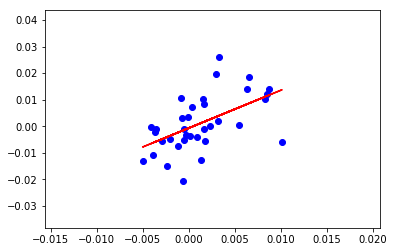

In [85]:
fitted_y_vals = lr.predict(x_vals)

x_vals
fitted_y_vals

import matplotlib.pyplot as plt
plt.scatter( x_vals, y_vals, color="blue")
plt.plot( x_vals, fitted_y_vals, color="red")
plt.show()
# pipe_reg.fit_transform( all_ids.loc[:, idx['FB',:]].tail(), un.loc[:, ["Pct", "SPY"]].tail())
                         

In [86]:
%aimport trans.reg
from trans.reg import Reg

fud.shape
r = Reg(fud2[s:e])

r_df = r.get(  [ idx["Pct", "SPY"] ],  idx["Pct", "AAPL"] )
r.fit( r_df )

#%%debug 
r = Reg(fud2)

r_df  = r.get(  [ idx["Pct", "SPY"] ], idx["Pct", "AAPL"])

res_df = r.rollingFit( r_df, 
                 pd.to_datetime("01/01/2017",infer_datetime_format=True),
                 pd.to_datetime("12/15/2017", infer_datetime_format=True),
                 timedelta(weeks=4)
            )

res_df

r = Reg(fud2)

res_df = r.rollingModel( [ idx["Pct", "SPY"] ],  idx["Pct", "AAPL"],
                 pd.to_datetime("01/01/2017",infer_datetime_format=True),
                 pd.to_datetime("12/15/2017", infer_datetime_format=True),
                 timedelta(weeks=4)
            )
res_df

(4528, 12)

(-0.00071338708618964939, array([ 1.42386037]))

,Intercept,Beta 1
Dt,,
2017-02-10,0.005502,0.312753
2017-03-10,0.001030,1.229487
2017-04-07,0.001885,1.238555
2017-05-05,0.000930,1.118177
2017-06-02,0.001291,1.259652
2017-06-30,-0.003231,2.051056
2017-07-28,0.000761,1.116566
2017-08-25,0.004471,1.736269
2017-09-22,-0.005043,1.837181


,Intercept,Beta 1
Dt,,
2017-02-10,0.005502,0.312753
2017-03-10,0.001030,1.229487
2017-04-07,0.001885,1.238555
2017-05-05,0.000930,1.118177
2017-06-02,0.001291,1.259652
2017-06-30,-0.003231,2.051056
2017-07-28,0.000761,1.116566
2017-08-25,0.004471,1.736269
2017-09-22,-0.005043,1.837181
